In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate
from scipy import interpolate

In [2]:
path="/Users/namh2/OneDrive/Documentos/DOCTORADO/AJUSTES Y ERRORES LANE-EMDEN/Blok_McGaugh_Rubin_2001/"
data=np.loadtxt(path+"U4115.dat")

In [3]:
RCr_data = np.array([row[1] for row in data])# galactocentric distance [kpc]
RCv_data = np.array([row[5] for row in data])# rotation velocity [km/s]
RCev_data = np.array([row[6] for row in data])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

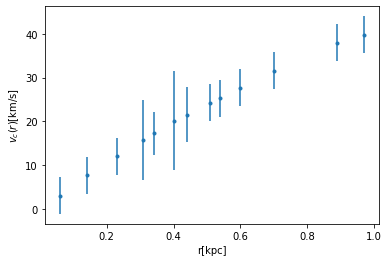

In [4]:
plt.errorbar(RCr_data,RCv_data,yerr=RCev_data,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [5]:
def Integrate(func,x0,y0,x,h):
    # Finds value of y for a given x using step size h 
    # and initial value y0 at x0.
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    #while x0 < x:
    while y0[0] > 0.1:
    #while y0[0] > 1.e-3:
         # Count number of iterations using step size or
        #h = min(h,x - x0)# step height h
        y0 = y0 + RK4(func,x0,y0,h)#update next value of y
        x0 = x0 + h#update next value of x
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [6]:
def rhs(x,y):
    dy=np.zeros(2)
    dy[0]=y[1]
    dy[1]=-2/x*y[1]-y[0]**n
    return dy

In [7]:
y0=np.zeros(2)
h=0.01
x0=0.0001
y0[0]=1.
y0[1]=0.

In [8]:
def rvmaxima(v,r,vmax):
    for i in range(len(v)):
        if v[i] == vmax:
            rvmax=r[i]
    return rvmax

In [9]:
def model(data,X,v,alpha,rhoc):
    V = []
    r = alpha*X
    RC = alpha*np.sqrt(G*rhoc)*v
    Int_l = interpolate.interp1d(r,RC)#,fill_value='extrapolate')
    for i in range(len(data)):
        if data[i] < r[-1]:
            v=Int_l(data[i])
            V.append(v)
        else:
            v=np.sqrt(G*m[-1]*alpha**3*rhoc/(data[i]))
            V.append(v)
    return V 

In [10]:
def Xi2(RCv_data,RCv_teo,RCev_data):
    xi=np.sum((RCv_data-RCv_teo)**2./(RCev_data)**2.)
    return xi

In [11]:
n=5
X,Y=Integrate(rhs,x0,y0,10.,h)

In [12]:
m=-4.*np.pi*X**2*Y[:,1]
v=np.sqrt(m/X)

In [13]:
Vmax=max(RCv_data)
vmax=max(v)
RVmax=rvmaxima(RCv_data,RCr_data,Vmax)
rvmax=rvmaxima(v,X,vmax)
print(Vmax)
print(vmax)
print(RVmax)
print(rvmax)

39.8
2.1992731934228087
0.97
2.450099999999992


In [14]:
G=4.258*10**(4)
alpha=RVmax/rvmax
rhoc=Vmax**2/vmax**2*1./(alpha**2*G)
print(alpha)
print(rhoc)

0.39590220807314114
0.049071154717690156


In [15]:
alpha_min=0.1
alpha_max=10.
rhoc_min=5e-4
rhoc_max=2e-2
alpha_vec=np.linspace(alpha_min,alpha_max,600)
rhoc_vec=np.linspace(rhoc_min,rhoc_max,600)

In [16]:
xi_minimo=1000
xi = np.zeros((len(alpha_vec),len(rhoc_vec)))
for l in range(0,len(alpha_vec)):
    for j in range(0,len(rhoc_vec)):
        V=model(RCr_data,X,v,alpha_vec[l],rhoc_vec[j])
        xi[l,j]=Xi2(RCv_data,V,RCev_data)
        if (xi[l,j] < xi_minimo):
            xi_minimo=xi[l,j]
            alpha_minimo=alpha_vec[l]
            rhoc_minimo=rhoc_vec[j]

In [17]:
print(alpha_minimo)
print(rhoc_minimo)
print(xi_minimo)

0.9429048414023372
0.014823873121869783
0.0562908352835733


In [18]:
V=model(RCr_data,X,v,alpha_minimo,rhoc_minimo)

Text(0.5, 0, 'R[kpc]')

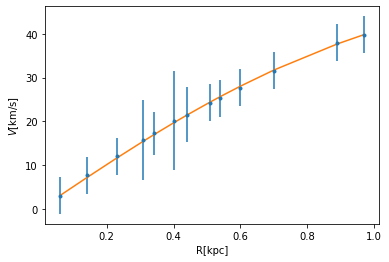

In [19]:
plt.errorbar(RCr_data,RCv_data,yerr=RCev_data,fmt='.')
plt.plot(RCr_data,V)
plt.ylabel(r'$V$[km/s]')
plt.xlabel("R[kpc]")

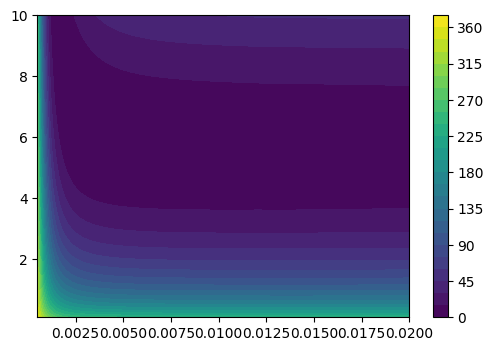

In [20]:
x,y = np.meshgrid(alpha_vec,rhoc_vec)
fig = plt.figure(dpi=100)
plt.contourf(y,x,xi,25,cmap='viridis')
#plt.xlabel(r'$g$')
#plt.ylabel(r'$K$')
plt.colorbar();

Text(0.5, 0, '$\\chi^2$')

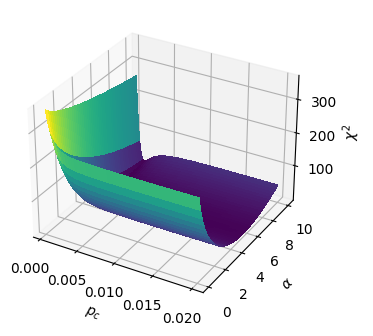

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},dpi=100)
surf = ax.plot_surface(y,x,xi,cmap='viridis',linewidth=0,antialiased=False)
ax.set_xlabel(r'$p_c$')
ax.set_ylabel(r'$\alpha$')
ax.set_zlabel(r'$\chi^2$')

In [22]:
xicl = np.zeros((len(alpha_vec),len(rhoc_vec)))
for l in range(0,len(alpha_vec)):
    for j in range(0,len(rhoc_vec)):
        if ((xi[l,j] - xi_minimo) <= 40):
            xicl[l,j]=xi[l,j]

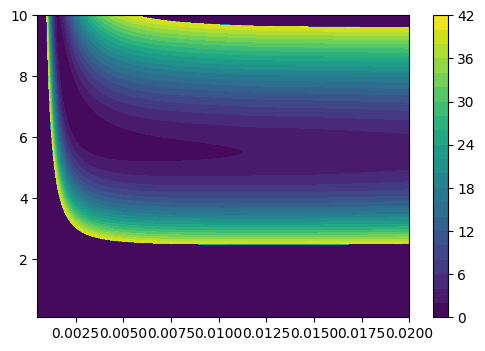

In [23]:
x,y = np.meshgrid(alpha_vec,rhoc_vec)
fig = plt.figure(dpi=100)
plt.contourf(y,x,xicl,25,cmap='viridis')
#plt.xlabel(r'$g$')
#plt.ylabel(r'$K$')
plt.colorbar();